In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import haversine as hs   
from haversine import Unit, haversine_vector
from shapely import Point, LineString, Polygon
import geopandas as gpd
import folium
import branca
import plotly.express as px
from geojson import Feature, FeatureCollection
from IPython.display import Image
from scipy.spatial.distance import jensenshannon

In [2]:
# Load data
df_real = pd.read_csv(
    "../data/train_small_cleaned.csv",
)

In [3]:
df_real.sample(5)

,TRIP_ID,TIMESTAMP,TRIP_DURATION,TRIP_LENGTH,TRIP_DISTANCE,START_POSITION,END_POSITION,POLYLINE
32241,1396284238620000098,1396284238,1350,90,5703.139522,"(41.151267, -8.609427)","(41.171454, -8.654904)","[(41.151267, -8.609427), (41.151519, -8.609346..."
5995,1389904275620000616,1389904275,330,22,1708.558653,"(41.148504, -8.638623)","(41.154768, -8.62884)","[(41.148504, -8.638623), (41.148504, -8.638812..."
37851,1389806604620000682,1389806604,540,36,3338.138757,"(41.182731, -8.600031)","(41.169222, -8.623206)","[(41.182731, -8.600031), (41.182839, -8.600202..."
65545,1395690336620000617,1395690336,750,50,4344.009296,"(41.145453, -8.607474)","(41.125437, -8.605161)","[(41.145453, -8.607474), (41.145453, -8.607465..."
116557,1389492025620000249,1389492025,405,27,3535.871801,"(41.140674, -8.615637)","(41.154165, -8.642043)","[(41.140674, -8.615637), (41.140476, -8.616438..."


In [4]:
# df_synthetic = pd.read_csv(
#     "../data/train_small_synthetic_cleaned.csv",
# )
# df_synthetic = df_synthetic.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [5]:
import pyarrow.parquet as pq
df_synthetic = pq.read_table('../data/synthetic_gps_data.parquet').to_pandas()

In [6]:
df_synthetic.sample(5)

,TIMESTAMP,TRIP_DURATION,TRIP_LENGTH,START_POSITION_LAT,START_POSITION_LONG,END_POSITION_LAT,END_POSITION_LONG,ROUTE_LENGTH,POLYLINE,START_POSITION,END_POSITION
95,1380108730,214.6,16,41.167305,-8.644635,41.144679,-8.655201,3079.102,"[[-8.6450922,41.1674101],[-8.647039131828056,4...",(-8.644635 41.167305),(-8.655201 41.144679)
1,1401797295,439.9,31,41.162364,-8.612217,41.136201,-8.610786,5714.975,"[[-8.612181,41.1628418],[-8.614291646115422,41...",(-8.612217 41.162364),(-8.610786 41.136201)
322,1380980019,557.5,39,41.143518,-8.610093,41.166144,-8.670213,7411.930,"[[-8.6104165,41.1434984],[-8.61091362776612,41...",(-8.610093 41.143518),(-8.670213 41.166144)
148,1403451621,623.5,43,41.163372,-8.616393,41.236506,-8.610939,10735.604,"[[-8.6163008,41.1633535],[-8.6187022,41.163656...",(-8.616393 41.163372),(-8.610939 41.236506)
868,1381875501,151.9,12,41.169843,-8.663913,41.162670,-8.669934,1797.927,"[[-8.6636254,41.1707971],[-8.66437475633417,41...",(-8.663913 41.169843),(-8.669934 41.16267)


In [7]:
df_synthetic['POLYLINE'] = df_synthetic['POLYLINE'].apply(lambda x: str([(y[1], y[0]) for y in eval(x)]))
df_synthetic['START_POSITION'] = df_synthetic['POLYLINE'].apply(lambda x: eval(x)[0])
df_synthetic['END_POSITION'] = df_synthetic['POLYLINE'].apply(lambda x: eval(x)[-1])
df_synthetic['TRIP_DISTANCE'] = df_synthetic['ROUTE_LENGTH']
df_synthetic.drop(columns=['ROUTE_LENGTH'], inplace=True)
df_synthetic.sample(5)

,TIMESTAMP,TRIP_DURATION,TRIP_LENGTH,START_POSITION_LAT,START_POSITION_LONG,END_POSITION_LAT,END_POSITION_LONG,POLYLINE,START_POSITION,END_POSITION,TRIP_DISTANCE
781,1402840546,325.5,23,41.144850,-8.614170,41.176341,-8.617401,"[(41.1452361, -8.6135865), (41.1459905, -8.612...","(41.1452361, -8.6135865)","(41.1759871, -8.6173072)",4377.928
854,1395305723,376.4,27,41.163696,-8.679456,41.150214,-8.630253,"[(41.1645364, -8.6775044), (41.16597721446317,...","(41.1645364, -8.6775044)","(41.1507222, -8.6304881)",4997.398
802,1383852480,61.8,6,41.148873,-8.584524,41.147253,-8.591661,"[(41.1488448, -8.5860712), (41.149338314285714...","(41.1488448, -8.5860712)","(41.1472887, -8.5908518)",770.691
718,1397360498,468.6,33,41.156406,-8.689383,41.137272,-8.649846,"[(41.1593345, -8.6837305), (41.160141854598535...","(41.1593345, -8.6837305)","(41.1374439, -8.6496223)",6977.799
769,1379356302,566.6,39,41.147955,-8.574687,41.161572,-8.652141,"[(41.1480808, -8.5738177), (41.14790988263422,...","(41.1480808, -8.5738177)","(41.1616226, -8.6516969)",10724.326


In [8]:
df_real = df_real.sample(df_synthetic.shape[0])

In [9]:
df_real.shape, df_synthetic.shape

((981, 8), (981, 11))

In [10]:
def plot_trips(df, n=100, color="blue", location=[41.17251, -8.61669], zoom_start=12):
    m = folium.Map(
        location=location,
        zoom_start=zoom_start,
        tiles="cartodbpositron",
        width=400,
        height=400,
    )

    for i, row in df.sample(n).iterrows():
        folium.PolyLine(
            locations=[[p[0], p[1]] for p in eval(row["POLYLINE"])],
            color=color,
            weight=3,
            opacity=0.6,
        ).add_to(m)

    return m

In [51]:
# Real trips
subplot_real = plot_trips(df_real, n=100, color="green")

# Synthetic trips
subplot_synthetic = plot_trips(df_synthetic, n=100, color="orange")

fig = branca.element.Figure(width=900, height=420, title="Real vs Synthetic Trips")
subplot1 = fig.add_subplot(1, 2, 1, margin=0.02)
subplot2 = fig.add_subplot(1, 2, 2, margin=0.02)
subplot1.add_child(subplot_real)
subplot2.add_child(subplot_synthetic)
fig

In [61]:
center_location = [41.15793, -8.62917]
zoom = 16

# Real trips
subplot_real = plot_trips(df_real, n=100, color="green", location=center_location, zoom_start=zoom)

# Synthetic trips
subplot_synthetic = plot_trips(df_synthetic, n=100, color="orange", location=center_location, zoom_start=zoom)

fig = branca.element.Figure(width=900, height=420, title="Real vs Synthetic Trips")
subplot1 = fig.add_subplot(1, 2, 1, margin=0.02)
subplot2 = fig.add_subplot(1, 2, 2, margin=0.02)
subplot1.add_child(subplot_real, name="Real Trips")
subplot2.add_child(subplot_synthetic, name="Synthetic Trips")
fig

## Accuracy on Location-Level

In [13]:
# Store all positions in a single array
all_coordinates_real = df_real["POLYLINE"].values
all_coordinates_real = [eval(x) for x in all_coordinates_real]
all_coordinates_real = [item for sublist in all_coordinates_real for item in sublist]
all_coordinates_real = np.array(all_coordinates_real)
df_all_coordinates_real = pd.DataFrame(all_coordinates_real, columns=["lat", "lon"])

all_coordinates_synthetic = df_synthetic["POLYLINE"].values
all_coordinates_synthetic = [eval(x) for x in all_coordinates_synthetic]
all_coordinates_synthetic = [item for sublist in all_coordinates_synthetic for item in sublist]
all_coordinates_synthetic = np.array(all_coordinates_synthetic)
df_all_coordinates_synthetic = pd.DataFrame(all_coordinates_synthetic, columns=["lat", "lon"])

In [14]:
N_HEGXAGONS_HORIZONTAL = 100

fig_real = ff.create_hexbin_mapbox(
    data_frame=df_all_coordinates_real, lat="lat", lon="lon",
    nx_hexagon=N_HEGXAGONS_HORIZONTAL, opacity=0.7, labels={"color": "Point Count"},
    min_count=1, 
    color_continuous_scale="turbo", # OrRd
    # show_original_data=True,
    # original_data_marker=dict(size=2, opacity=0.2, color="deeppink")
)
# fig_real.update_layout(mapbox_style="carto-positron")
# fig_real.show()

fig_synthetic = ff.create_hexbin_mapbox(
    data_frame=df_all_coordinates_synthetic, lat="lat", lon="lon",
    nx_hexagon=N_HEGXAGONS_HORIZONTAL, opacity=0.7, labels={"color": "Point Count"},
    min_count=1,
    color_continuous_scale="turbo", # OrRd
    # show_original_data=True,
    # original_data_marker=dict(size=2, opacity=0.2, color="deeppink")
)
# fig_synthetic.update_layout(mapbox_style="carto-positron")
# fig_synthetic.show()

In [15]:
# Create dataframe with all hexagons and their number of points in it
coordinates = [feature['geometry']['coordinates'] for feature in fig_real.data[0].geojson['features']]
coordinates = np.array(coordinates)[:,0]
coordinates = np.array([[[x[1], x[0]] for x in y] for y in coordinates])
values = fig_real.data[0]['z']
hexbins_df = pd.DataFrame({'coordinates': list(coordinates), 'n_points_real': values})
hexbins_df['n_points_real'] = hexbins_df['n_points_real'].astype(int)
hexbins_df['geometry'] = hexbins_df['coordinates'].apply(lambda x: LineString(x))

hexbins_gdf = gpd.GeoDataFrame(hexbins_df, geometry='geometry')
hexbins_gdf['centroid'] = hexbins_gdf['geometry'].centroid
hexbins_df['centroid'] = hexbins_gdf['centroid']
hexbins_df['centroid-lat'] = hexbins_df['centroid'].apply(lambda x: x.x)
hexbins_df['centroid-lon'] = hexbins_df['centroid'].apply(lambda x: x.y)

In [16]:
hexbins_df.sample(5)

,coordinates,n_points_real,geometry,centroid,centroid-lat,centroid-lon
2036,"[[41.14903516497976, -8.62684537505182], [41.1...",37,LINESTRING (41.14903516497976 -8.6268453750518...,POINT (41.14994 -8.62685),41.149936,-8.626845
2255,"[[41.138220650890155, -8.610263055018656], [41...",23,LINESTRING (41.138220650890155 -8.610263055018...,POINT (41.13912 -8.61026),41.139122,-8.610263
2152,"[[41.15444175323251, -8.618554215035237], [41....",75,LINESTRING (41.15444175323251 -8.6185542150352...,POINT (41.15534 -8.61855),41.155343,-8.618554
453,"[[41.217935763226116, -8.63824572007462], [41....",5,LINESTRING (41.217935763226116 -8.638245720074...,POINT (41.21884 -8.63825),41.218836,-8.638246
1150,"[[41.18281902613392, -8.58228038996269], [41.1...",9,LINESTRING (41.18281902613392 -8.5822803899626...,POINT (41.18372 -8.58228),41.183720,-8.582280


In [17]:
# Classify the number of points in 3 categories: hot-spots (top 1%), frequently-visted (top 2-10%), and less-visited (bottom 90%)
hexbins_df['n_points_real_category'] = pd.qcut(hexbins_df['n_points_real'], q=[0, 0.9, 0.99, 1], labels=["less-visited", "frequently-visited", "hot-spots"])

In [18]:
# Add number of points in synthetic data to most N visited hexagons
def count_points_in_hexagon(hexagon, points):
    polygon = Polygon(hexagon)
    return sum([Point(x).covered_by(polygon) for x in points])

TOP_N_PLACES = 50
top_n_hexagons_df = hexbins_df.copy()
top_n_hexagons_df = top_n_hexagons_df.sort_values('n_points_real', ascending=False).head(TOP_N_PLACES)
all_coordinates_synthetic_copy = all_coordinates_synthetic.copy()
top_n_hexagons_df['n_points_synthetic'] = top_n_hexagons_df['coordinates'].apply(lambda x: count_points_in_hexagon(x, all_coordinates_synthetic_copy))

In [19]:
# Add relative frequency of real and synthetic points
top_n_hexagons_df['n_points_real_relative'] = top_n_hexagons_df['n_points_real'] / all_coordinates_real.shape[0]
top_n_hexagons_df['n_points_synthetic_relative'] = top_n_hexagons_df['n_points_synthetic'] / all_coordinates_synthetic.shape[0]

In [20]:
top_n_hexagons_df.head(5)

,coordinates,n_points_real,geometry,centroid,centroid-lat,centroid-lon,n_points_real_category,n_points_synthetic,n_points_real_relative,n_points_synthetic_relative
805,"[[41.14497993119057, -8.611299450020727], [41....",636,LINESTRING (41.14497993119057 -8.6112994500207...,POINT (41.14588 -8.61130),41.145881,-8.611299,hot-spots,50,0.013315,0.001831
1105,"[[41.14768344824971, -8.586425969970982], [41....",558,LINESTRING (41.14768344824971 -8.5864259699709...,POINT (41.14858 -8.58643),41.148585,-8.586426,hot-spots,22,0.011682,0.000806
2291,"[[41.14633170365323, -8.608190265014509], [41....",508,LINESTRING (41.14633170365323 -8.6081902650145...,POINT (41.14723 -8.60819),41.147233,-8.608190,hot-spots,64,0.010636,0.002344
2258,"[[41.14633170365323, -8.610263055018656], [41....",404,LINESTRING (41.14633170365323 -8.6102630550186...,POINT (41.14723 -8.61026),41.147233,-8.610263,hot-spots,56,0.008458,0.002051
2123,"[[41.14633170365323, -8.620627005039383], [41....",308,LINESTRING (41.14633170365323 -8.6206270050393...,POINT (41.14723 -8.62063),41.147233,-8.620627,hot-spots,70,0.006448,0.002563


In [21]:
# swap lat and lon for plotly
top_n_hexagons_df['polygons_plotly'] = top_n_hexagons_df['coordinates'].apply(lambda x: Polygon([[y[1], y[0]] for y in x]))
top_n_hexagons_df['index'] = top_n_hexagons_df.index

In [22]:
def hexagons_dataframe_to_geojson(df_hex, hex_id_field, geometry_field, value_field):
    list_features = []

    for i, row in df_hex.iterrows():
        feature = Feature(geometry = row[geometry_field],
                          id = row[hex_id_field],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feature_collection = FeatureCollection(list_features)

    return feature_collection

geojson_real = hexagons_dataframe_to_geojson(top_n_hexagons_df, 'index', 'polygons_plotly', 'n_points_real')
geojson_synthetic = hexagons_dataframe_to_geojson(top_n_hexagons_df, 'index', 'polygons_plotly', 'n_points_synthetic')

In [23]:
top_n_hexagons_df.head(5)

,coordinates,n_points_real,geometry,centroid,centroid-lat,centroid-lon,n_points_real_category,n_points_synthetic,n_points_real_relative,n_points_synthetic_relative,polygons_plotly,index
805,"[[41.14497993119057, -8.611299450020727], [41....",636,LINESTRING (41.14497993119057 -8.6112994500207...,POINT (41.14588 -8.61130),41.145881,-8.611299,hot-spots,50,0.013315,0.001831,POLYGON ((-8.611299450020727 41.14497993119057...,805
1105,"[[41.14768344824971, -8.586425969970982], [41....",558,LINESTRING (41.14768344824971 -8.5864259699709...,POINT (41.14858 -8.58643),41.148585,-8.586426,hot-spots,22,0.011682,0.000806,POLYGON ((-8.586425969970982 41.14768344824971...,1105
2291,"[[41.14633170365323, -8.608190265014509], [41....",508,LINESTRING (41.14633170365323 -8.6081902650145...,POINT (41.14723 -8.60819),41.147233,-8.608190,hot-spots,64,0.010636,0.002344,POLYGON ((-8.608190265014509 41.14633170365323...,2291
2258,"[[41.14633170365323, -8.610263055018656], [41....",404,LINESTRING (41.14633170365323 -8.6102630550186...,POINT (41.14723 -8.61026),41.147233,-8.610263,hot-spots,56,0.008458,0.002051,POLYGON ((-8.610263055018656 41.14633170365323...,2258
2123,"[[41.14633170365323, -8.620627005039383], [41....",308,LINESTRING (41.14633170365323 -8.6206270050393...,POINT (41.14723 -8.62063),41.147233,-8.620627,hot-spots,70,0.006448,0.002563,POLYGON ((-8.620627005039383 41.14633170365323...,2123


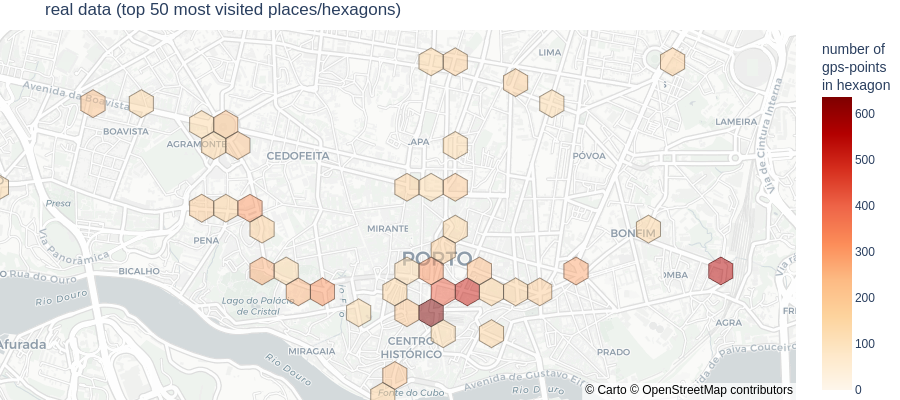

In [24]:
fig_hexa_real = px.choropleth_mapbox(
    top_n_hexagons_df, geojson=geojson_real, locations='index', color='n_points_real',
    color_continuous_scale="OrRd", # OrRd
    range_color=(0, top_n_hexagons_df['n_points_real'].max()),
    mapbox_style="carto-positron",
    zoom=13, center = {"lat": 41.15220, "lon": -8.61414},
    opacity=0.5,
    labels={'n_points_real':'number of<br>gps-points<br>in hexagon'},
    title=f'real data (top {TOP_N_PLACES} most visited places/hexagons)',
    width=900,
    height=400,
)
fig_hexa_real.update_layout(margin=dict(b=0, t=30, l=0, r=0))
fig_hexa_real.update_traces(hovertemplate='%{z}')
# fig_hexa_real.show()
png_hexa_real = fig_hexa_real.to_image(format="png", width=900, height=400, scale=1)
Image(png_hexa_real)

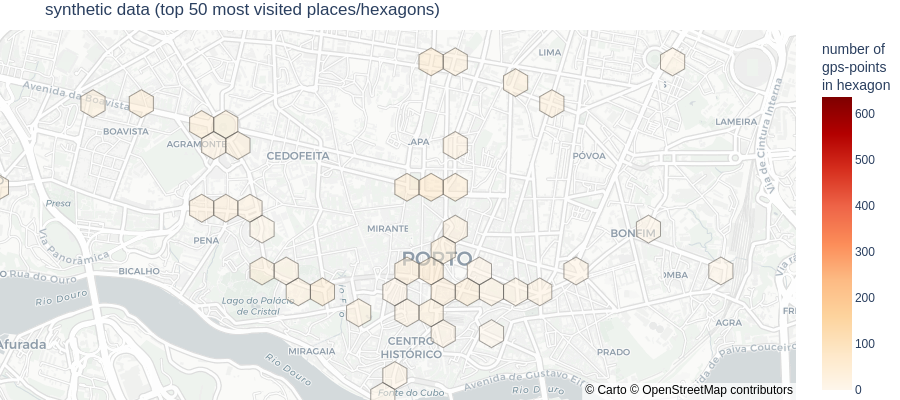

In [25]:
fig_hexa_sythetic = px.choropleth_mapbox(
    top_n_hexagons_df, geojson=geojson_synthetic, locations='index', color='n_points_synthetic',
    color_continuous_scale="OrRd", # OrRd
    range_color=(0, top_n_hexagons_df['n_points_real'].max()),
    mapbox_style="carto-positron",
    zoom=13, center = {"lat": 41.15220, "lon": -8.61414},
    opacity=0.5,
    labels={'n_points_synthetic':'number of<br>gps-points<br>in hexagon'},
    title=f'synthetic data (top {TOP_N_PLACES} most visited places/hexagons)',
    width=900,
    height=400,
)
fig_hexa_sythetic.update_layout(margin=dict(b=0, t=30, l=0, r=0))
fig_hexa_sythetic.update_traces(hovertemplate='%{z}')
# fig_hexa_sythetic.show()
png_hexa_sythetic = fig_hexa_sythetic.to_image(format="png", width=900, height=400, scale=1)
Image(png_hexa_sythetic)

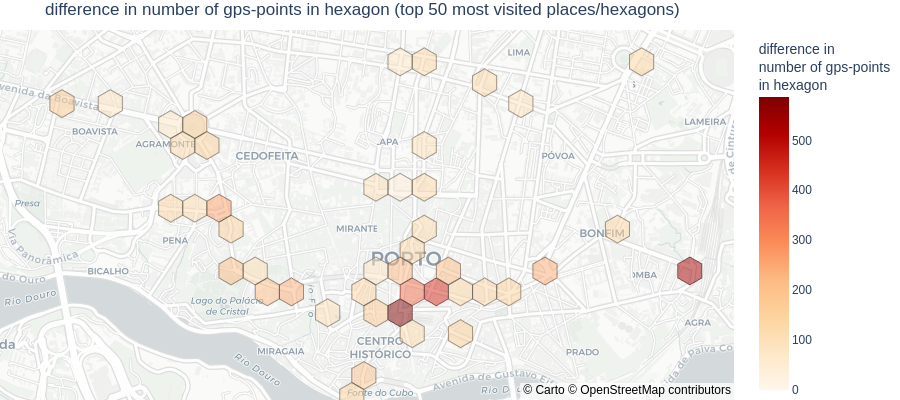

In [26]:
top_n_hexagons_df['n_points_diff'] = (top_n_hexagons_df['n_points_real'] - top_n_hexagons_df['n_points_synthetic']).abs()
fig_hexa_diff = px.choropleth_mapbox(
    top_n_hexagons_df, geojson=geojson_real, locations='index', color='n_points_diff',
    color_continuous_scale="OrRd", # OrRd
    range_color=(0, top_n_hexagons_df['n_points_diff'].max()),
    mapbox_style="carto-positron",
    zoom=13, center = {"lat": 41.15220, "lon": -8.61414},
    opacity=0.5,
    labels={'n_points_diff':'difference in<br>number of gps-points<br>in hexagon'},
    title=f'difference in number of gps-points in hexagon (top {TOP_N_PLACES} most visited places/hexagons)',
    width=900,
    height=400,
)
fig_hexa_diff.update_layout(margin=dict(b=0, t=30, l=0, r=0))
fig_hexa_diff.update_traces(hovertemplate='%{z}')
# fig_hexa_diff.show()
png_hexa_diff = fig_hexa_diff.to_image(format="png", width=900, height=400, scale=1)
Image(png_hexa_diff)

In [27]:
# Plot frequency of top N visited places (hexagons) - Real vs Synthetic
top_n_hexagons_df = top_n_hexagons_df.sort_values('n_points_real', ascending=False).reset_index()
top_n_hexagons_df['n_hexagon'] = top_n_hexagons_df.index
top_n_hexagons_df_chart = pd.melt(top_n_hexagons_df, id_vars=['n_hexagon'], value_vars=['n_points_real_relative', 'n_points_synthetic_relative'], var_name='data', value_name='n_points')
top_n_hexagons_df_chart['data'] = top_n_hexagons_df_chart['data'].apply(lambda x: 'Real' if x == 'n_points_real_relative' else 'Synthetic')

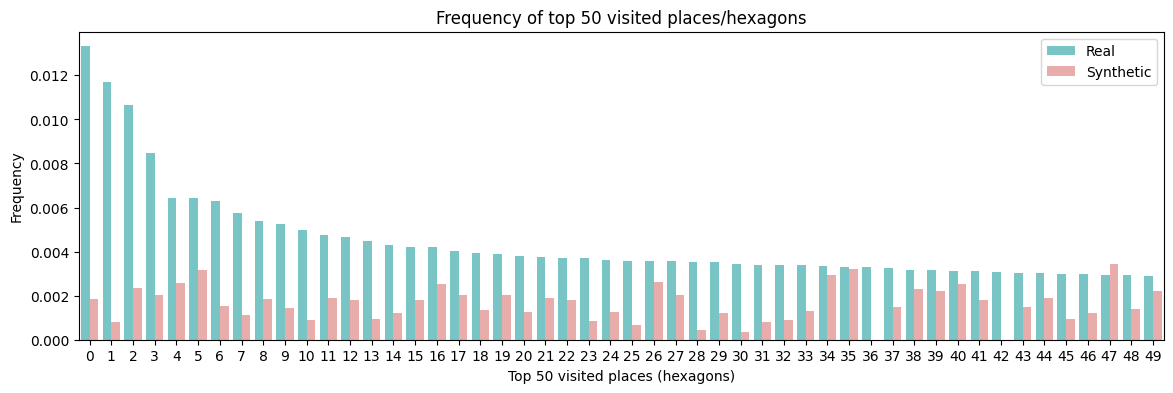

In [28]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.title(f"Frequency of top {TOP_N_PLACES} visited places/hexagons")
plt.xlabel(f"Top {TOP_N_PLACES} visited places (hexagons)")
plt.ylabel("Frequency")
sns.barplot(x='n_hexagon', y='n_points', hue='data', data=top_n_hexagons_df_chart.sort_values(['data', 'n_points'], ascending=[True, False]), palette=['#6CD1D2', '#F3A29F'])
plt.legend(title='')
plt.show()

In [29]:
100 / top_n_hexagons_df['n_points_real_relative'].mean()

22464.490640579435

In [30]:
top_n_hexagons_df['n_points_real_relative'].mean()

0.004451469726153589

In [31]:
max(top_n_hexagons_df['n_points_real_relative'] - top_n_hexagons_df['n_points_synthetic_relative'])

0.011484435380240614

In [32]:
# Calculate hotspot difference between real and synthetic data (Mean absolute difference between real and synthetic data in top N visited places)
hotspot_difference = top_n_hexagons_df['n_points_real_relative'] - top_n_hexagons_df['n_points_synthetic_relative']
hotspot_difference = hotspot_difference.abs()
hotspot_difference = hotspot_difference.sum() / TOP_N_PLACES
# Normalize hotspot difference (Mean absolute difference between real and synthetic data in top N visited places)
hotspot_difference_normalized = hotspot_difference / top_n_hexagons_df['n_points_real_relative'].mean()
print(f"Normalized Mean Absolute Difference of Top k Visited Places Share: {hotspot_difference_normalized:.2f}")

Normalized Mean Absolute Difference of Top k Visited Places Share: 0.64


In [33]:
hexbins_df_category = hexbins_df.copy()[['coordinates', 'n_points_real_category', 'n_points_real']]

In [34]:
hexbins_df_category['polygons_plotly'] = hexbins_df_category['coordinates'].apply(lambda x: Polygon([[y[1], y[0]] for y in x]))
hexbins_df_category['index'] = hexbins_df_category.index

In [35]:
hexbins_df_category.sample(5)

,coordinates,n_points_real_category,n_points_real,polygons_plotly,index
2809,"[[41.09223907140087, -8.546006564890144], [41....",less-visited,1,POLYGON ((-8.546006564890144 41.09223907140087...,2809
1820,"[[41.165253592097045, -8.64550048508913], [41....",less-visited,41,POLYGON ((-8.64550048508913 41.165253592097045...,1820
329,"[[41.17471248799978, -8.648609670095349], [41....",less-visited,24,POLYGON ((-8.648609670095349 41.17471248799978...,329
87,"[[41.163902209777575, -8.677628730153385], [41...",less-visited,1,POLYGON ((-8.677628730153385 41.16390220977757...,87
970,"[[41.09359193050653, -8.598862709995855], [41....",less-visited,2,POLYGON ((-8.598862709995855 41.09359193050653...,970


In [36]:
geojson_real_category = hexagons_dataframe_to_geojson(hexbins_df_category, 'index', 'polygons_plotly', 'n_points_real_category')

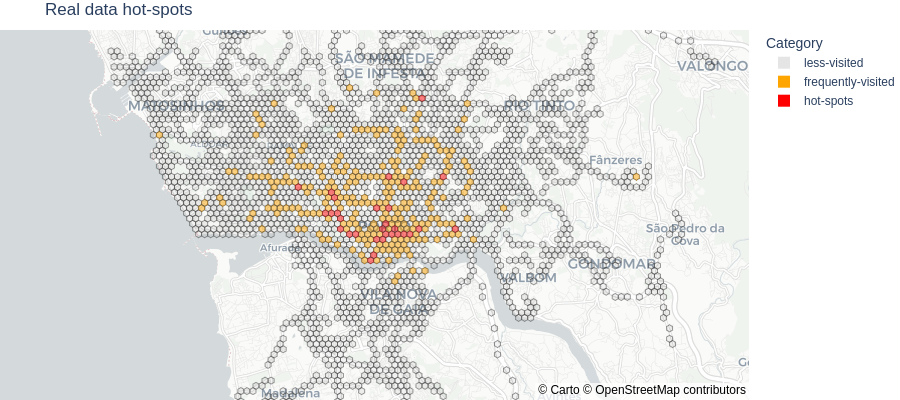

In [37]:
fig_hexa_real_category = px.choropleth_mapbox(
    hexbins_df_category, geojson=geojson_real_category, locations='index', color='n_points_real_category',
    color_discrete_map={"hot-spots": "red", "frequently-visited": "orange", "less-visited": "rgba(0,0,0,0.1)"},
    mapbox_style="carto-positron",
    zoom=11, center = {"lat": 41.15220, "lon": -8.61414},
    opacity=0.5,
    title=f'Real data hot-spots',
    hover_data={'n_points_real': True, 'n_points_real_category': False, 'index': False},
    width=900,
    height=400,
    labels={'n_points_real_category':'Category'},
)
fig_hexa_real_category.update_layout(margin=dict(b=0, t=30, l=0, r=0))
# fig_hexa_real_category.show()
png_hexa_real_category = fig_hexa_real_category.to_image(format="png", width=900, height=400, scale=1)
Image(png_hexa_real_category)

## Accuracy on Trip-Level

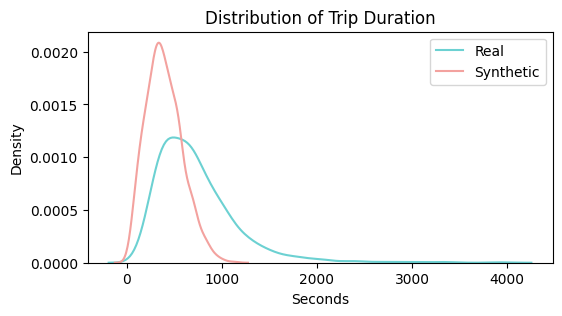

In [38]:
# Plot distribution of trip duration
fig, ax = plt.subplots(figsize=(6, 3))
plt.title("Distribution of Trip Duration")
plt.xlabel("Seconds")
plt.ylabel("Density")
sns.kdeplot(df_real["TRIP_DURATION"], label="Real", color="#6CD1D2", ax=ax)
sns.kdeplot(df_synthetic["TRIP_DURATION"], label="Synthetic", color="#F3A29F", ax=ax)
plt.legend()
plt.show()

In [39]:
# Calculate probability distribution of trip duration
bins = np.linspace(0, df_real["TRIP_DURATION"].max(), 100)
real_duration_prob, _ = np.histogram(df_real["TRIP_DURATION"], bins=bins, density=True)
synthetic_duration_prob, _ = np.histogram(df_synthetic["TRIP_DURATION"], bins=bins, density=True)

# Calculate Jensen-Shannon divergence
jsd_duration = jensenshannon(real_duration_prob, synthetic_duration_prob)
jsd_duration

0.4071807692651467

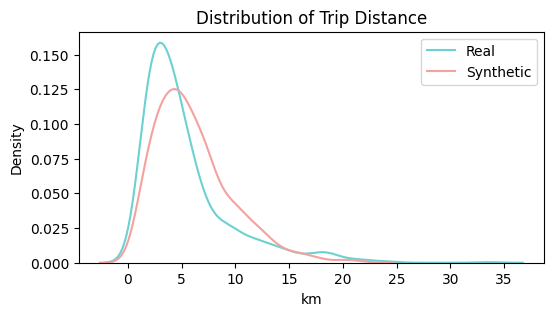

In [40]:
# Plot distribution of trip distance
fig, ax = plt.subplots(figsize=(6, 3))
plt.title("Distribution of Trip Distance")
plt.xlabel("km")
plt.ylabel("Density")
sns.kdeplot(df_real["TRIP_DISTANCE"] / 1000, label="Real", color="#6CD1D2", ax=ax)
sns.kdeplot(df_synthetic["TRIP_DISTANCE"] / 1000, label="Synthetic", color="#F3A29F", ax=ax)
plt.legend()
plt.show()

In [41]:
# Calculate probability distribution of trip distance
bins = np.linspace(0, df_real["TRIP_DISTANCE"].max(), 100)
real_distance_prob, _ = np.histogram(df_real["TRIP_DISTANCE"], bins=bins, density=True)
synthetic_distance_prob, _ = np.histogram(df_synthetic["TRIP_DISTANCE"], bins=bins, density=True)

# Calculate Jensen-Shannon divergence
jsd_distance = jensenshannon(real_distance_prob, synthetic_distance_prob)
jsd_distance

0.21508684404362474

In [42]:
# Calculate the straightness index of the trips (ratio of the origin-destination distance to the full traveled distance)
df_real['OD_DISTANCE'] = df_real.apply(lambda x: hs.haversine(eval(x['START_POSITION']), eval(x['END_POSITION']), unit=Unit.METERS), axis=1)
df_real['STRAIGHTNESS_INDEX'] = df_real['OD_DISTANCE'] / df_real['TRIP_DISTANCE']
# df_synthetic['OD_DISTANCE'] = df_synthetic.apply(lambda x: hs.haversine(eval(x['START_POSITION']), eval(x['END_POSITION']), unit=Unit.METERS), axis=1)
df_synthetic['OD_DISTANCE'] = df_synthetic.apply(lambda x: hs.haversine(x['START_POSITION'], x['END_POSITION'], unit=Unit.METERS), axis=1)
df_synthetic['STRAIGHTNESS_INDEX'] = df_synthetic['OD_DISTANCE'] / df_synthetic['TRIP_DISTANCE']

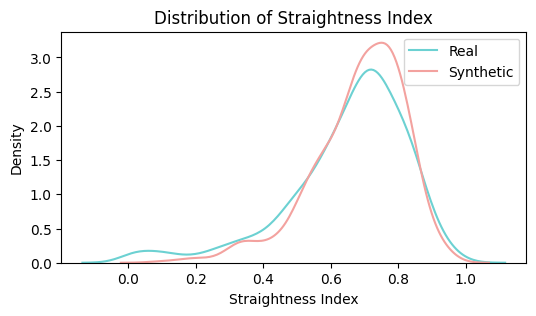

In [43]:
# Plot distribution of straightness index
fig, ax = plt.subplots(figsize=(6, 3))
plt.title("Distribution of Straightness Index")
plt.xlabel("Straightness Index")
plt.ylabel("Density")
sns.kdeplot(df_real["STRAIGHTNESS_INDEX"], label="Real", color="#6CD1D2", ax=ax)
sns.kdeplot(df_synthetic["STRAIGHTNESS_INDEX"], label="Synthetic", color="#F3A29F", ax=ax)
plt.legend()
plt.show()

In [44]:
# Calculate probability distribution of straightness index
bins = np.linspace(0, 1, 100)
real_straightness_prob, _ = np.histogram(df_real["STRAIGHTNESS_INDEX"], bins=bins, density=True)
synthetic_straightness_prob, _ = np.histogram(df_synthetic["STRAIGHTNESS_INDEX"], bins=bins, density=True)

# Calculate Jensen-Shannon divergence
jsd_straightness = jensenshannon(real_straightness_prob, synthetic_straightness_prob)
jsd_straightness

0.1922750726422358

In [45]:
# Calculate the the radius of gyration (measures how far on average the trip is from its center of mass/trip)
def calculate_gyration_radius(polyline, center_of_mass):
    # Convert the polyline and center_of_mass to numpy arrays
    polyline_array = np.array(eval(polyline))
    center_of_mass_array = np.array(center_of_mass)

    # Calculate the distance from each GPS point to the center of mass
    distances = np.array([])
    for point in polyline_array:
        distance = hs.haversine(center_of_mass_array, point, unit=Unit.METERS)
        distances = np.append(distances, distance)

    # Calculate the gyration radius using the formula: sqrt(sum((d_i - d_avg)^2) / n)
    avg_distance = np.mean(distances)
    # squared_distances = (distances - avg_distance) ** 2
    # gyration_radius = np.sqrt(np.sum(squared_distances) / len(polyline))

    return avg_distance

df_real['CENTER_OF_MASS'] = df_real['POLYLINE'].apply(lambda x: np.mean(eval(x), axis=0))
df_real['GYRATION_RADIUS'] = df_real.apply(lambda row: calculate_gyration_radius(row['POLYLINE'], row['CENTER_OF_MASS']), axis=1)
df_real = df_real.drop(columns=['CENTER_OF_MASS'])   

df_synthetic['CENTER_OF_MASS'] = df_synthetic['POLYLINE'].apply(lambda x: np.mean(eval(x), axis=0))
df_synthetic['GYRATION_RADIUS'] = df_synthetic.apply(lambda row: calculate_gyration_radius(row['POLYLINE'], row['CENTER_OF_MASS']), axis=1)
df_synthetic = df_synthetic.drop(columns=['CENTER_OF_MASS'])

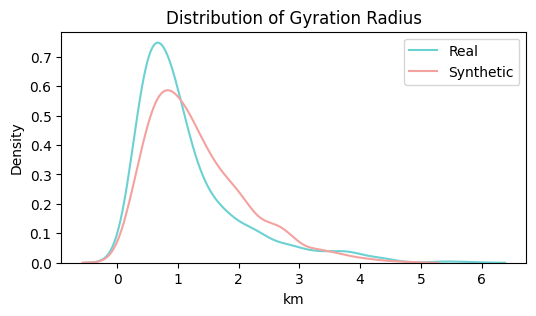

In [46]:
# Plot distribution of gyration radius
fig, ax = plt.subplots(figsize=(6, 3))
plt.title("Distribution of Gyration Radius")
plt.xlabel("km")
plt.ylabel("Density")
sns.kdeplot(df_real["GYRATION_RADIUS"] / 1000, label="Real", color="#6CD1D2", ax=ax)
sns.kdeplot(df_synthetic["GYRATION_RADIUS"] / 1000, label="Synthetic", color="#F3A29F", ax=ax)
plt.legend()
plt.show()

In [47]:
# Calculate probability distribution of gyration radius
bins = np.linspace(0, df_real["GYRATION_RADIUS"].max(), 100)
real_gyration_prob, _ = np.histogram(df_real["GYRATION_RADIUS"], bins=bins, density=True)
synthetic_gyration_prob, _ = np.histogram(df_synthetic["GYRATION_RADIUS"], bins=bins, density=True)

# Calculate Jensen-Shannon divergence
jsd_gyration = jensenshannon(real_gyration_prob, synthetic_gyration_prob)
jsd_gyration

0.19420498548014223

In [48]:
# Create metrics dataframe
metrics = pd.DataFrame({
    "Hotspot Difference": [hotspot_difference_normalized],
    "JSD Duration": [jsd_duration],
    "JSD Distance": [jsd_distance],
    "JSD Straightness": [jsd_straightness],
    "JSD Gyration": [jsd_gyration],
})
metrics

,Hotspot Difference,JSD Duration,JSD Distance,JSD Straightness,JSD Gyration
0,0.637827,0.407181,0.215087,0.192275,0.194205


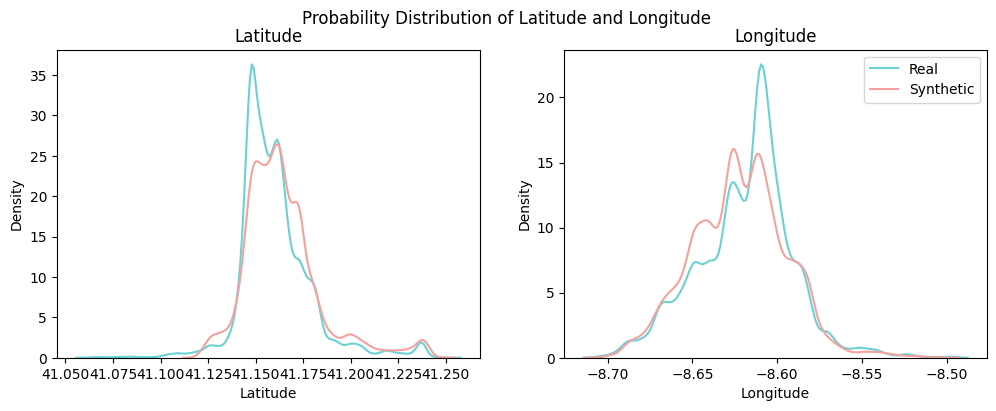

In [49]:
# plot probability distribution of all latitudes and longitudes in real and synthetic data
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("Probability Distribution of Latitude and Longitude")
sns.kdeplot(all_coordinates_real[:, 0], label="Real", color="#6CD1D2", ax=ax[0])
sns.kdeplot(all_coordinates_synthetic[:, 0], label="Synthetic", color="#F3A29F", ax=ax[0])
ax[0].set_title("Latitude")
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Density")
sns.kdeplot(all_coordinates_real[:, 1], label="Real", color="#6CD1D2", ax=ax[1])
sns.kdeplot(all_coordinates_synthetic[:, 1], label="Synthetic", color="#F3A29F", ax=ax[1])
ax[1].set_title("Longitude")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Density")
plt.legend()
plt.show()